### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the dataset
df = pd.read_csv('used_cars.csv')  

In [4]:
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


### Dataset Structure Overview

The dataset consists of 4,009 records with 12 features, including both categorical and numerical variables. Several columns, such as fuel type, engine, accident history, and clean title status, contain missing values. Identifying these gaps at the outset enables us to plan effective cleaning and ensures our analysis and modeling steps are built on a solid, reliable foundation.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   object
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.0+ KB


### Missing Values Analysis

Before proceeding with data preprocessing and modeling, it is essential to assess the presence of missing values within the dataset. Identifying columns with missing data enables us to design robust data cleaning strategies and ensures that the downstream machine learning models are not adversely affected by incomplete information.

The table below presents the count of missing values for each feature in the dataset:

brand, model, model_year, milage, engine, transmission, ext_col, int_col, price:
These features have complete data with zero missing values.

**fuel_type**:
Contains 170 missing values, indicating some records do not specify the type of fuel used. Addressing these missing entries is crucial since fuel type can influence car price and performance.

**accident**:
Has 113 missing values, which may represent instances where accident history is not reported. As accident records can be a strong determinant of resale value, special attention should be given to these entries during data cleaning.

**clean_title**:
Exhibits the highest number of missing values (596 records). Since title status is a significant indicator of a car's legal and financial standing, handling these missing entries appropriately is important for building trustworthy models.


In [6]:
df.isna().sum()

brand             0
model             0
model_year        0
milage            0
fuel_type       170
engine            0
transmission      0
ext_col           0
int_col           0
accident        113
clean_title     596
price             0
dtype: int64

Missing values in the accident, fuel type, and clean title columns were filled with the label "Unknown." This approach preserves all records for analysis and ensures that no information is lost due to incomplete data in these key categorical features.

In [7]:
# Fill missing values in the 'accident' column with 'Unknown'
df['accident'] = df['accident'].fillna('Unknown')
print(df['accident'].value_counts(dropna=False))

accident
None reported                             2910
At least 1 accident or damage reported     986
Unknown                                    113
Name: count, dtype: int64


In [8]:
# Fill missing values in multiple columns
df['fuel_type'] = df['fuel_type'].fillna('Unknown')
df['clean_title'] = df['clean_title'].fillna('Unknown')

To enable proper analysis, we cleaned the price and milage columns by removing symbols (like $, commas, and unit labels) and converted them to integers. This ensures both features are ready for numerical modeling and analysis.

In [9]:
df['price'] = df['price'].str.replace('$', '').str.replace(',', '').astype(int)
df['milage'] = df['milage'].str.replace(' mi.', '').str.replace(',', '').astype(int)

In [10]:
df['price']

0        10300
1        38005
2        54598
3        15500
4        34999
         ...  
4004    349950
4005     53900
4006     90998
4007     62999
4008     40000
Name: price, Length: 4009, dtype: int32

## Exploratory Data Analysis

### Top 20 Car Models by Frequency

To explore the most popular vehicles in the dataset, we visualized the top 20 car models by their frequency. This barplot highlights which models appear most often in the dataset, providing insight into market trends and model representation. Identifying the most common car models helps us understand the dataset’s composition and can guide further analysis on price, features, and demand.

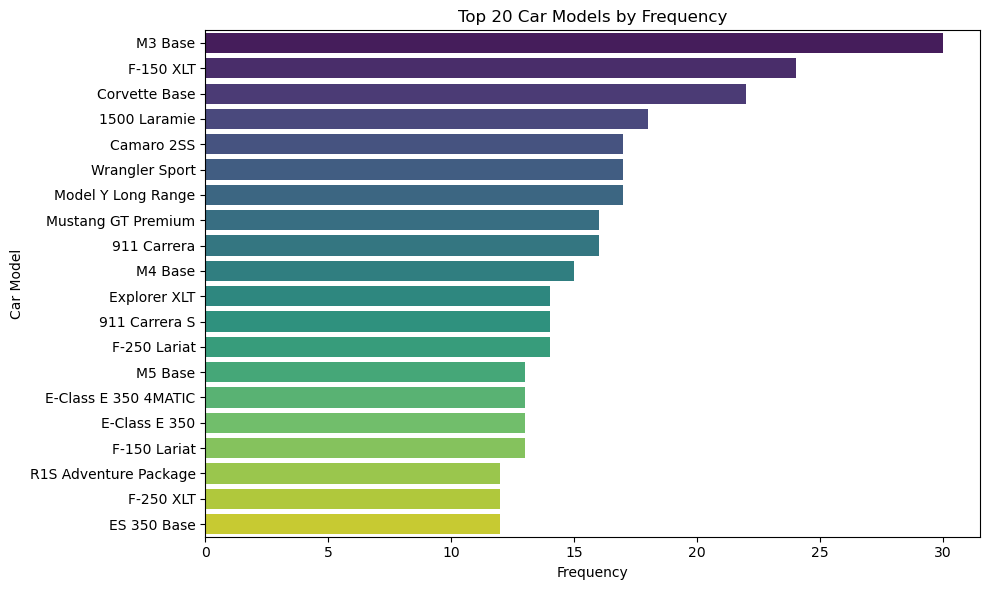

In [11]:
n = 20  # Number of top car models to plot
top_car_models = df['model'].value_counts().head(n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_car_models.values, y=top_car_models.index, palette='viridis')
plt.title(f'Top {n} Car Models by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Car Model')
plt.tight_layout()
plt.show()

### Distribution of Selling Price

This histogram shows that most car prices are concentrated at the lower end, with a strong right skew due to a few extremely high-priced outliers. The presence of these outliers can distort model performance and highlights the importance of outlier detection and removal for accurate price prediction.

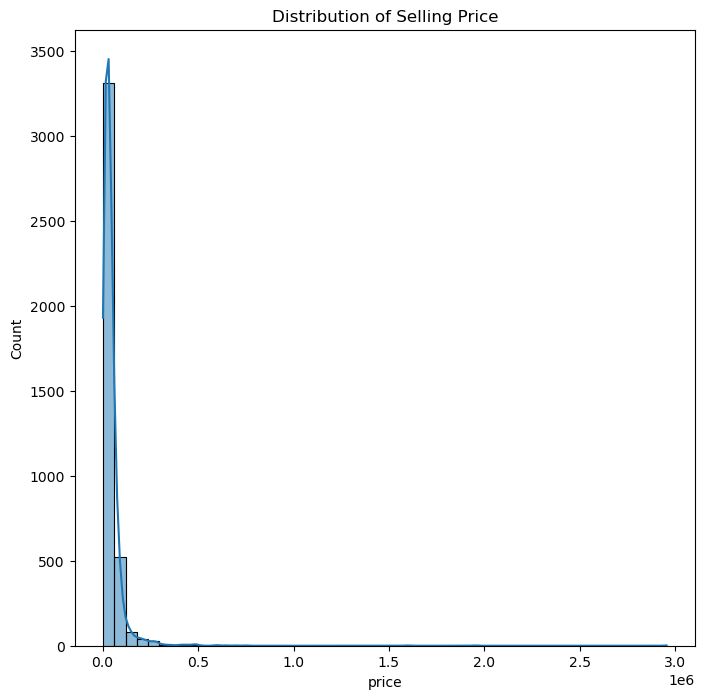

In [12]:
plt.figure(figsize=(8,8))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution of Selling Price')
plt.show()

### Price vs. Model Year

The scatter plot shows that newer cars tend to have higher prices, with a few extreme outliers indicating rare or luxury vehicles.


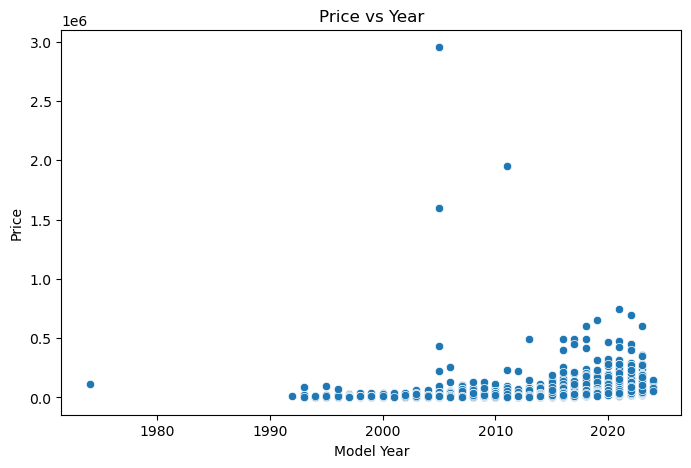

In [13]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='model_year', y='price', data=df)
plt.title('Price vs Year')
plt.xlabel('Model Year')
plt.ylabel('Price')
plt.show()

### High-Price Outliers

These three cars, each priced above $1.5 million, are clear outliers—as seen in the earlier plots. Removing them can help improve model accuracy for the general car market.

In [14]:
df[df['price'] > 1500000]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
229,Bugatti,Veyron 16.4 Grand Sport,2011,6330,Gasoline,8.0L W16 64V GDI DOHC Twin Turbo,7-Speed Automatic with Auto-Shift,White,White,None reported,Yes,1950995
693,Maserati,Quattroporte Base,2005,32000,Gasoline,394.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Red,Beige,At least 1 accident or damage reported,Yes,2954083
3046,Porsche,Carrera GT Base,2005,4400,Gasoline,605.0HP 5.7L 10 Cylinder Engine Gasoline Fuel,6-Speed M/T,Gray,Black,None reported,Yes,1599000


In [15]:
df = df[df['price'] < 1500000]

### Feature Engineering

In this step, we create several new features to better capture key aspects of each vehicle:

    Car Age: The number of years since the car was manufactured, which often correlates with price depreciation.

    Mileage per Year: A normalized measure of vehicle usage, calculated as total mileage divided by age.

    Is Luxury Brand: A binary indicator for well-known luxury brands, as these tend to retain value differently.

    Is Recent Model: Flags cars that are three years old or newer, since newer models are typically more expensive.

    We also handle any infinite or missing values that may result from these calculations to ensure clean input for modeling.

These engineered features provide the models with more meaningful signals, which helps improve prediction accuracy.

In [16]:
import datetime

current_year = datetime.datetime.now().year

# 1. Car Age
df['car_age'] = current_year - df['model_year']

# 2. Mileage per Year
df['milage_per_year'] = df['milage'] / df['car_age'].replace(0, 1)  # Avoid division by zero

# 3. Is Luxury Brand (simple example list)
luxury_brands = ['BMW', 'Mercedes-Benz', 'Porsche', 'Lexus', 'Audi', 'Land Rover', 'Maserati', 'Bugatti']
df['is_luxury_brand'] = df['brand'].isin(luxury_brands).astype(int)

# 4. Is Recent Model
df['is_recent_model'] = (df['car_age'] <= 3).astype(int)

# Fill any infinite or NaN values 
df['milage_per_year'] = df['milage_per_year'].replace([np.inf, -np.inf], np.nan).fillna(df['milage_per_year'].median())


In [17]:
print(df.dtypes)

brand               object
model               object
model_year           int64
milage               int32
fuel_type           object
engine              object
transmission        object
ext_col             object
int_col             object
accident            object
clean_title         object
price                int32
car_age              int64
milage_per_year    float64
is_luxury_brand      int32
is_recent_model      int32
dtype: object


### Correlation Matrix

This heatmap shows how price, mileage, and model year relate to each other. Price increases with newer model years and decreases with higher mileage. Notably, there’s a moderate negative correlation between model year and mileage, indicating that newer cars typically have lower mileage.

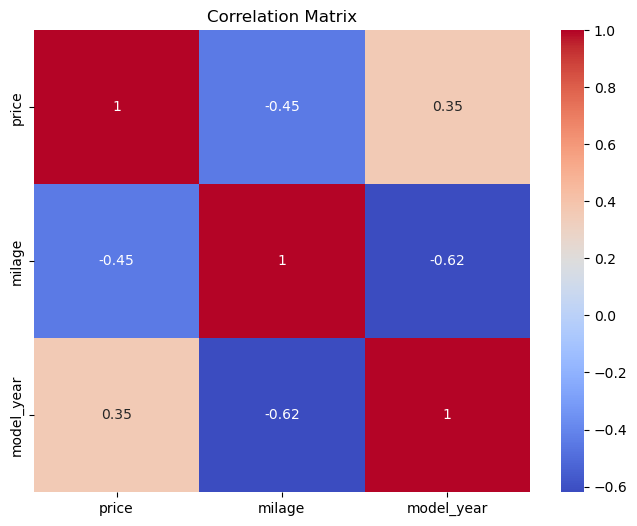

In [18]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[['price', 'milage', 'model_year']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Milage vs. Log(Price)

This plot shows that cars with higher mileage generally have lower log-transformed prices, highlighting a clear negative relationship between mileage and value.

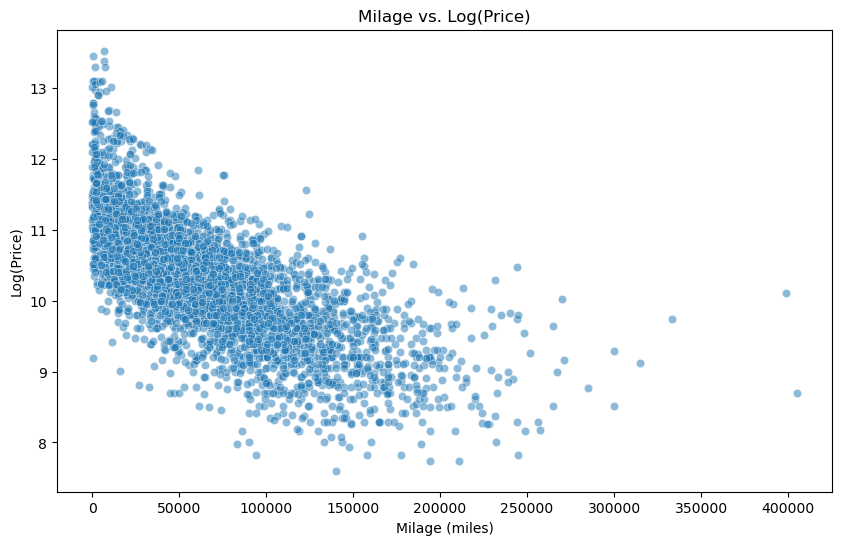

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['milage'], y=np.log(df['price']), alpha=0.5)
plt.title('Milage vs. Log(Price)')
plt.xlabel('Milage (miles)')
plt.ylabel('Log(Price)')
plt.show()

### Top 10 Car Brands

This barplot displays the ten most common car brands in the dataset. Ford, BMW, and Mercedes-Benz are the most frequently listed brands, reflecting their strong market presence.

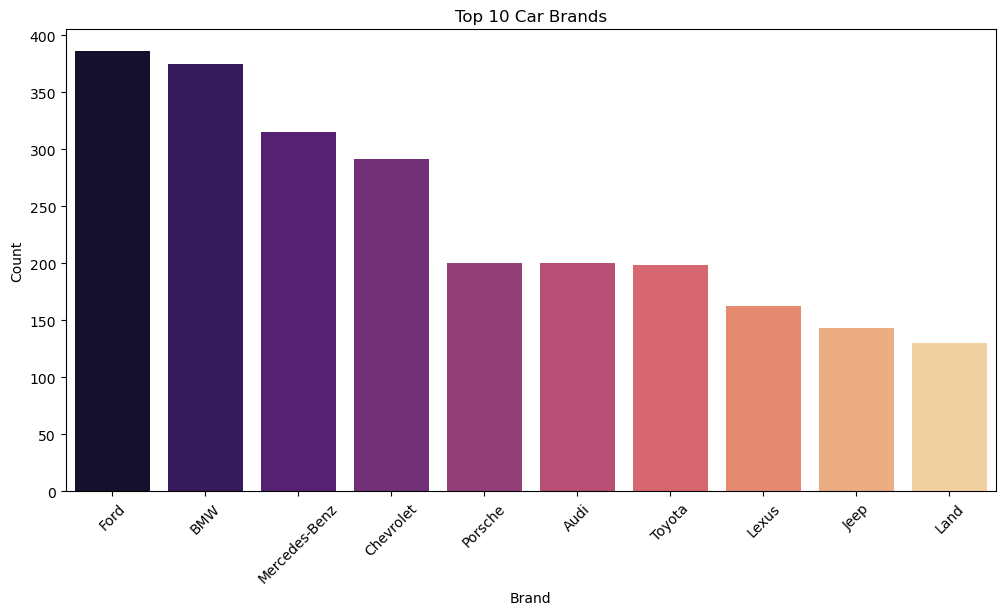

In [20]:
plt.figure(figsize=(12, 6))
top_brands = df['brand'].value_counts().head(10)
sns.barplot(x=top_brands.index, y=top_brands.values, palette='magma')
plt.title('Top 10 Car Brands')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Fuel Type Distribution

This barplot shows that gasoline is by far the most common fuel type in the dataset, vastly outnumbering all other categories.

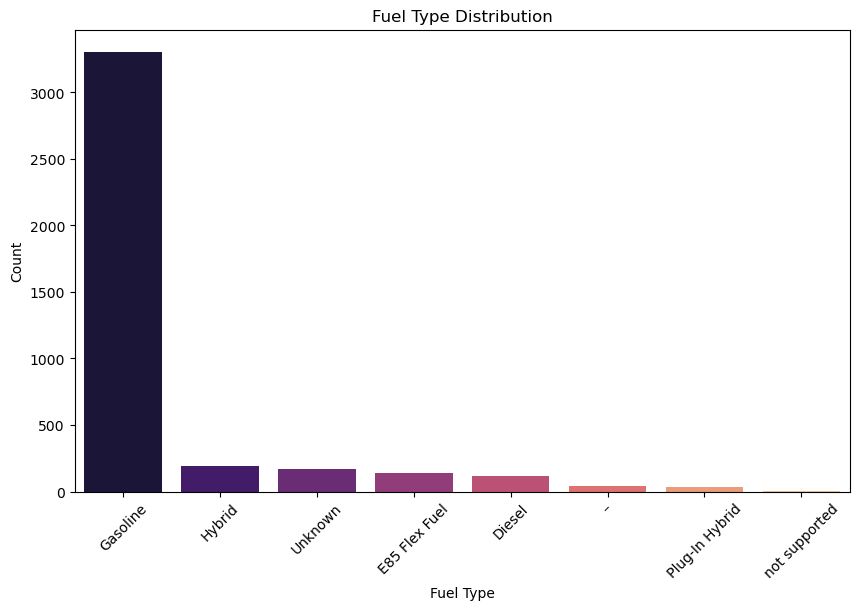

In [21]:
# Bar chart for fuel_type (including NaN)
plt.figure(figsize=(10, 6))
fuel_counts = df['fuel_type'].value_counts(dropna=False)
sns.barplot(x=fuel_counts.index.astype(str), y=fuel_counts.values, palette='magma')
plt.title('Fuel Type Distribution')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
# Insight: Gasoline is the dominant fuel type, far exceeding all other categories.
plt.show()

In [22]:
df['accident'].value_counts()

accident
None reported                             2908
At least 1 accident or damage reported     985
Unknown                                    113
Name: count, dtype: int64

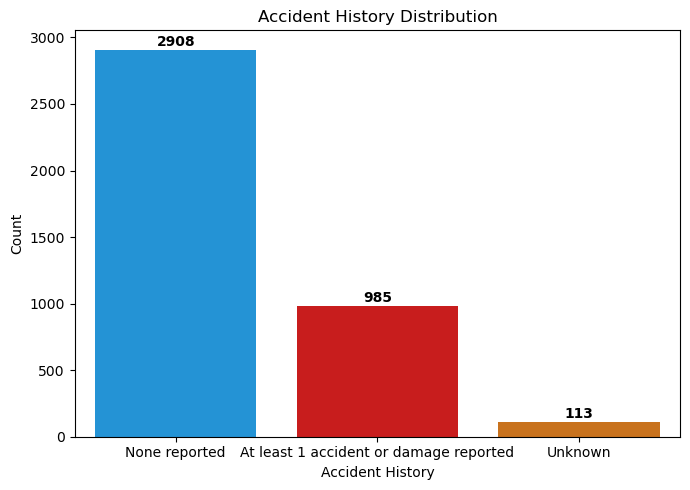

In [23]:
# Count values
accident_counts = df['accident'].value_counts()

# Custom colors
colors = ['#069AF3', '#E50000',  "#E57200"]

plt.figure(figsize=(7,5))
sns.barplot(x=accident_counts.index, y=accident_counts.values, palette=colors)
plt.title('Accident History Distribution')
plt.xlabel('Accident History')
plt.ylabel('Count')

# Add value labels on top of the bars
for i, v in enumerate(accident_counts.values):
    plt.text(i, v + 30, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


### Encoding Categorical Features
Categorical features such as brand, model, fuel type, and others were converted to numerical form using one-hot encoding, making the dataset suitable for machine learning models.

In [24]:
# Encode categorical features (one-hot for simplicity)
cat_cols = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 
            'ext_col', 'int_col', 'accident', 'clean_title']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

### Feature Selection and Data Splitting

The dataset was separated into features and target, with "price" set as the prediction target. We then split the data into training and test sets to evaluate model performance on unseen data.

In [25]:
# Feature matrix and target
X = df.drop(['price'], axis=1)
y = df['price']

In [26]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Evaluation and Comparison

We evaluated four regression models—Linear Regression, Random Forest, Gradient Boosting, and K-Nearest Neighbors—using MAE, RMSE, and R² as metrics. Random Forest performed best, achieving the lowest errors and highest R² (0.73), meaning it explains most of the variance in car prices. Gradient Boosting also showed strong performance. In contrast, Linear Regression and KNN had higher errors and much lower R² scores, indicating they were less effective for this task. Overall, tree-based ensemble methods proved superior for predicting used car prices in this dataset.

In [27]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Gradient Boosting
gb = GradientBoostingRegressor(random_state=42, n_estimators=100)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

In [28]:
from sklearn.neighbors import KNeighborsRegressor

# Standardize features for KNN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN Regression
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

In [29]:
# Evaluate models
results = {}

for name, y_pred in zip(
    ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'KNN'],
    [y_pred_lr, y_pred_rf, y_pred_gb, y_pred_knn]
):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

results_df = pd.DataFrame(results).T
print(results_df)


                            MAE          RMSE        R2
Linear Regression  17775.326060  45429.374260  0.229325
Random Forest      11413.451534  26974.554411  0.728289
Gradient Boosting  14100.899665  28415.444050  0.698486
KNN                19108.248379  43989.108926  0.277416


### Model Performance Comparison Plots: R² Score and RMSE

These two bar plots provide a clear visual comparison of regression model performance using both R² score and RMSE. The R² plot shows how well each model explains the variance in car prices, with higher values indicating a better fit. The RMSE plot displays the average prediction error, where lower values mean better performance. Reviewing both plots together, we see that Random Forest and Gradient Boosting models achieve higher R² and lower RMSE than KNN and Linear Regression, making them the most effective options for predicting used car prices in this dataset.

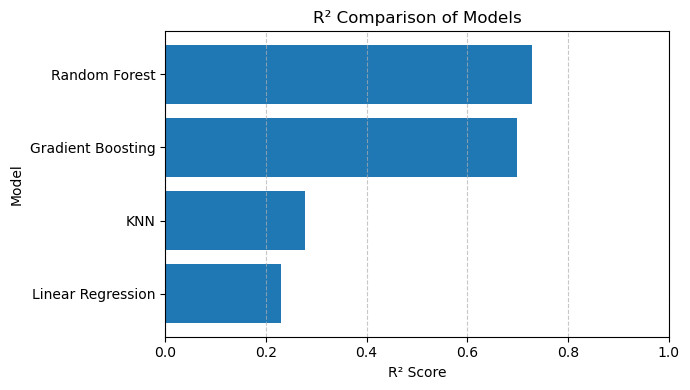

In [30]:
# Sort the DataFrame by R² in descending order
results_sorted = results_df.sort_values('R2', ascending=False)

# Prepare data for plotting, reverse for highest at top
model_names = results_sorted.index.tolist()[::-1]
r2_scores = results_sorted['R2'].tolist()[::-1]

plt.figure(figsize=(7, 4))
plt.barh(model_names, r2_scores)
plt.xlabel('R² Score')
plt.ylabel('Model')
plt.title('R² Comparison of Models')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

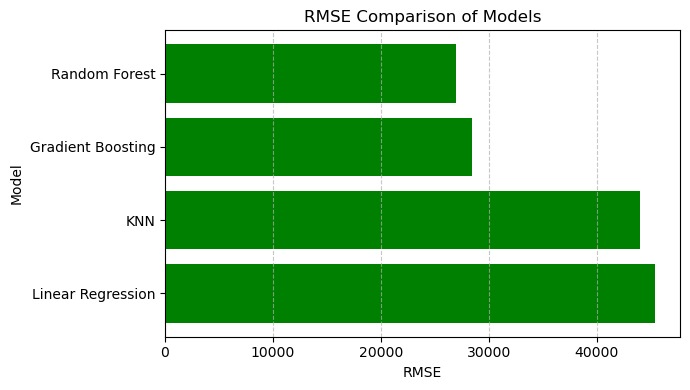

In [31]:
results_sorted = results_df.sort_values('RMSE', ascending=True)
model_names = results_sorted.index.tolist()[::-1]  # Reverse for best at top
rmse_scores = results_sorted['RMSE'].tolist()[::-1]

plt.figure(figsize=(7, 4))
plt.barh(model_names, rmse_scores, color='green')
plt.xlabel('RMSE')
plt.ylabel('Model')
plt.title('RMSE Comparison of Models')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Model Evaluation on Log-Transformed Price

We trained the Random Forest model to predict log(price) instead of raw price to address the skewed distribution and reduce the impact of outliers. This approach resulted in an RMSE of 0.39 and an R² score of 0.76, showing strong predictive performance on the log scale. Using the log transformation helps the model focus on proportional price differences and produce more balanced, reliable predictions.

In [32]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [33]:
rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_train, y_train_log)
y_pred_log_rf = rf.predict(X_test)

In [34]:
rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log_rf))
r2_log = r2_score(y_test_log, y_pred_log_rf)

print("Random Forest RMSE (log-scale):", rmse_log)
print("Random Forest R² Score (log-scale):", r2_log)

Random Forest RMSE (log-scale): 0.3926508008877254
Random Forest R² Score (log-scale): 0.7587638883487561


### XGBoost Model on Log-Transformed Price

We used XGBoost to predict log-transformed car prices because it handles nonlinearity and outliers effectively. XGBoost was selected due to its strong performance with structured data. The model achieved an RMSE of 0.34 and an R² of 0.82 on the log scale, showing improved accuracy and a strong fit.

In [35]:
from xgboost import XGBRegressor

# Initialize and train XGBoost
xgb = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train_log)

# Predict on test set
y_pred_log_xgb = xgb.predict(X_test)

In [36]:
rmse_log_xgb = np.sqrt(mean_squared_error(y_test_log, y_pred_log_xgb))
r2_log_xgb = r2_score(y_test_log, y_pred_log_xgb)

print("XGBoost RMSE (log scale):", rmse_log_xgb)
print("XGBoost R² (log scale):", r2_log_xgb)


XGBoost RMSE (log scale): 0.3414280425724837
XGBoost R² (log scale): 0.8175987875032968


### Comparison of XGBoost and Random Forest on Log-Transformed Price (with Plots)

This comparison evaluates the predictive accuracy of XGBoost and Random Forest models for used car price prediction using log-transformed targets. Both models’ performances are visualized by plotting the predicted versus actual log-prices. The results show that XGBoost slightly outperforms Random Forest, achieving a lower RMSE (0.34 vs. 0.39) and a higher R² score (0.82 vs. 0.76) on the log scale.

In [37]:
results = {}

for name, y_pred in zip(['Random Forest (Log)', 'XGBoost (Log)'], [y_pred_log_rf , y_pred_log_xgb]):
    rmse = np.sqrt(mean_squared_error(y_test_log, y_pred))
    r2 = r2_score(y_test_log, y_pred)
    results[name] = {'RMSE (log)': rmse, 'R2 (log)': r2}

results_df = pd.DataFrame(results).T
print(results_df)

                     RMSE (log)  R2 (log)
Random Forest (Log)    0.392651  0.758764
XGBoost (Log)          0.341428  0.817599


In the scatter plots, XGBoost’s predictions align more closely to the ideal reference line, indicating improved predictive accuracy and better generalization for the data.

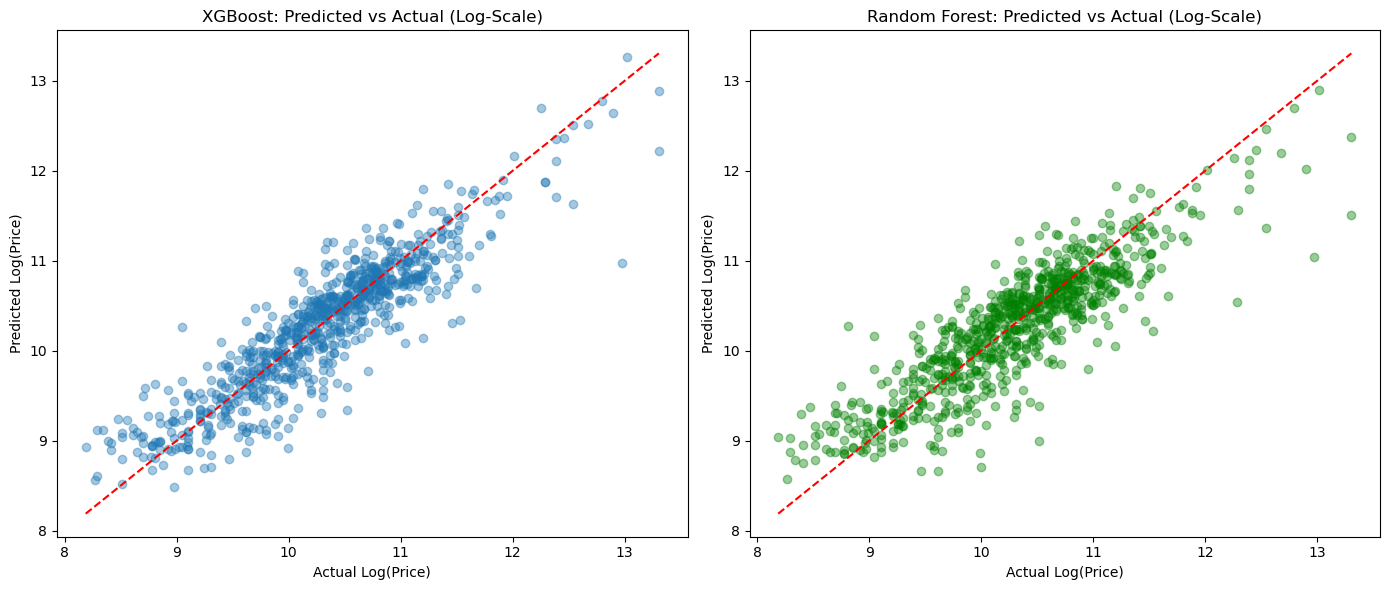

In [38]:
plt.figure(figsize=(14,6))

# XGBoost
plt.subplot(1, 2, 1)
plt.scatter(y_test_log, y_pred_log_xgb, alpha=0.4, label='Predicted')
plt.plot([y_test_log.min(), y_test_log.max()], [y_test_log.min(), y_test_log.max()], 'r--')
plt.xlabel('Actual Log(Price)')
plt.ylabel('Predicted Log(Price)')
plt.title('XGBoost: Predicted vs Actual (Log-Scale)')

# Random Forest
plt.subplot(1, 2, 2)
plt.scatter(y_test_log, y_pred_log_rf, alpha=0.4, color='g', label='Predicted')
plt.plot([y_test_log.min(), y_test_log.max()], [y_test_log.min(), y_test_log.max()], 'r--')
plt.xlabel('Actual Log(Price)')
plt.ylabel('Predicted Log(Price)')
plt.title('Random Forest: Predicted vs Actual (Log-Scale)')

plt.tight_layout()
plt.show()
